# Guide on how to use the backtester

In [1]:
# Ensure the project root is in PATH.
import sys
sys.path.append("..")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [2]:
from datamodel import OrderDepth, UserId, TradingState, Order, ConversionObservation, Observation

MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"


class Trader:
    def __init__(self):
        # config
        self.position_limit = 75

        self.bid_price_1 = []
        self.ask_price_1 = []
        self.obs_actual_ask = []
        self.obs_actual_bid = []

        pass

    def run(self, state: TradingState):
        result = {}
        orders = []
        conversions = 0

        # controlling position limits
        max_position = state.position.get(MAGNIFICENT_MACARONS, 0)
        min_position = state.position.get(MAGNIFICENT_MACARONS, 0)

        # market data
        sellorders = state.order_depths[MAGNIFICENT_MACARONS].sell_orders
        buyorders = state.order_depths[MAGNIFICENT_MACARONS].buy_orders
        obs = state.observations.conversionObservations[MAGNIFICENT_MACARONS]

        local_best_ask = min(sellorders)
        local_best_bid = max(buyorders)
        chef_real_ask = obs.askPrice + obs.importTariff + obs.transportFees
        chef_real_bid = obs.bidPrice - obs.exportTariff - obs.transportFees

        # # market taking - (rare)
        # for price, qty in sorted(buyorders.items(), reverse=True):
        #     # sell to them
        #     if price > chef_real_ask:
        #         qty_execute = min(qty, abs(-self.position_limit - min_position))
        #         orders.append(Order(MAGNIFICENT_MACARONS, price, -qty_execute))
        #         min_position -= qty_execute
        #     else:
        #         break

        # market making (modification-  sell always, instead of just selling when we are net 0)
        price_to_quote = local_best_bid + 4
        if min_position < 0:
            price_to_quote = local_best_bid + 4 + (2 * (-min_position))

        orders.append(Order(MAGNIFICENT_MACARONS, int(price_to_quote), -abs(-self.position_limit - min_position)))
        min_position = -self.position_limit

        result[MAGNIFICENT_MACARONS] = orders

        if max_position < 0:
            if len(self.obs_actual_ask) != 0:
                prev_ask = self.obs_actual_ask[-1]
                prev_bid = self.obs_actual_bid[-1]
                prev_spread = prev_ask - prev_bid
                curr_spread = chef_real_ask - chef_real_bid

                # when it spikes a little and is a bit more expensive then dont buy
                # based on the data it stays quite consistent except for little spikes.
                # check spreading.ipynb for spread research
                if curr_spread > prev_spread:
                    conversions = 0
                else:
                    conversions = min(10, -max_position)
            else:
                conversions = min(10, -max_position)

        self.bid_price_1.append(local_best_bid)
        self.ask_price_1.append(local_best_ask)
        self.obs_actual_ask.append(chef_real_ask)
        self.obs_actual_bid.append(chef_real_bid)

        return result, conversions, ""

Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [3]:
# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

Lets run the backtester

In [4]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    # "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    # "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    # "JAMS": Listing(symbol="JAMS", product="JAMS", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    # "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    # "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    # "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
    "MAGNIFICENT_MACARONS": Listing(symbol="MAGNIFICENT_MACARONS", product="MAGNIFICENT_MACARONS", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    # "CROISSANTS": 250,
    # "DJEMBES": 60,
    # "JAMS": 350,
    # "KELP": 50,
    # "PICNIC_BASKET1": 60,
    # "PICNIC_BASKET2": 100,
    # "RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
    # "VOLCANIC_ROCK": 400,
    # "VOLCANIC_ROCK_VOUCHER_10000": 200,
    # "VOLCANIC_ROCK_VOUCHER_10250": 200,
    # "VOLCANIC_ROCK_VOUCHER_10500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9750": 200,
    "MAGNIFICENT_MACARONS": 75,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object
# trader = Trader()

# from deployment.final.macaron_deployment import MacaronTrader
# trader = MacaronTrader()
# 6. Instantiate Backtester object
trader = Trader()
bt = Backtester(trader, listings, position_limit, market_data_round_5_all3days, trades_round_5_all3days, observations_round_5_all3days)


bt.run()


# double layer dictionary.

totalpnl = bt.pnl()["spreadcrossing"]["total"]
totalpnl, bt.pnl()

(2499.5000000000027,
 {'spreadcrossing': {'MAGNIFICENT_MACARONS': 2499.5000000000027,
   'total': 2499.5000000000027},
  'midpoint': {'MAGNIFICENT_MACARONS': 2641.5000000000027,
   'total': 2641.5000000000027}})

ok i think with the spread strat, I observe that when placing huge orders of sell 75, they are taken by a bot on the imc website (not in local backtester) instantly, for full size. This is probably true if i increase the size too.  

I tried placing sell orders of size 75 at local_best_bid + 1,2,3,4,5 and found that with 1,2,3 it was the exact same, and with 4, i had a slightly less fills, and with 5, it never got filled at full size.  

So just like last year ther eis a big taker bot in the market.  

I think what we have to do is keep a large inventory so that we can sell to this taker bot when the time is right.  

We can only do conversions when we have a negative position, so we want to be able to have always negative position.  

Don't really want to buy from local market even when the price spikes downwards because it doesn't spike down enough to make it worth it, unless we want to reach $0^-$ faster? I don't think its worth it.  

A very basic strat is the $+4$ strat, this is guaranteed to work. But I just need to optimise this more. This makes about 2600 over 100k timestamps.  

I tried to have the bot sell whenever, instead of only when position 0, but i got less pnl.  
does the big taker bot only take in large volumes? And not small volumes?  
But that doesn't make sense because if that was true then my small trades wouldn't go through, only my large trades.  

Maybe also we shouldn't buy sometimes when the price of the chefs' ask is too high?

You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.

Let's look at some metrics now.

Note:
- `get_metric` function is now deleted.
- `bt.pnl` is also deleted.
- If you want metrics, use `calculate_metrics(product)`.

Old way:
    bt.get_metric('midpoint_sharpe', 'KELP')

New way:
    metrics = bt.calculate_metrics('KELP')
    metric = metrics['midpoint_sharpe']

Available metrics:
0: timestamp
1: spreadcrossing_pnl
2: spreadcrossing_final_pnl
3: spreadcrossing_sharpe
4: spreadcrossing_pnl_bps
5: midpoint_pnl
6: midpoint_final_pnl
7: midpoint_sharpe
8: midpoint_pnl_bps
9: position


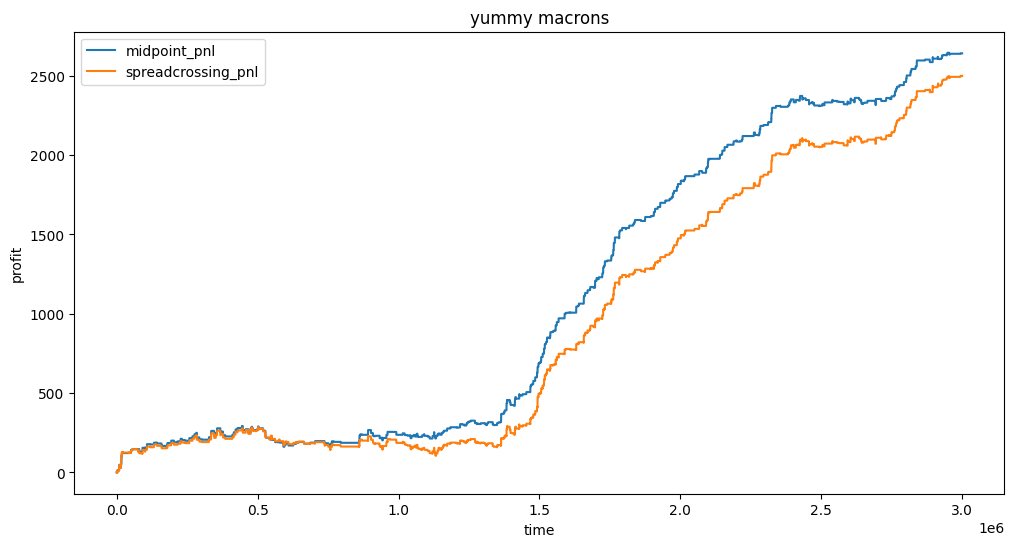

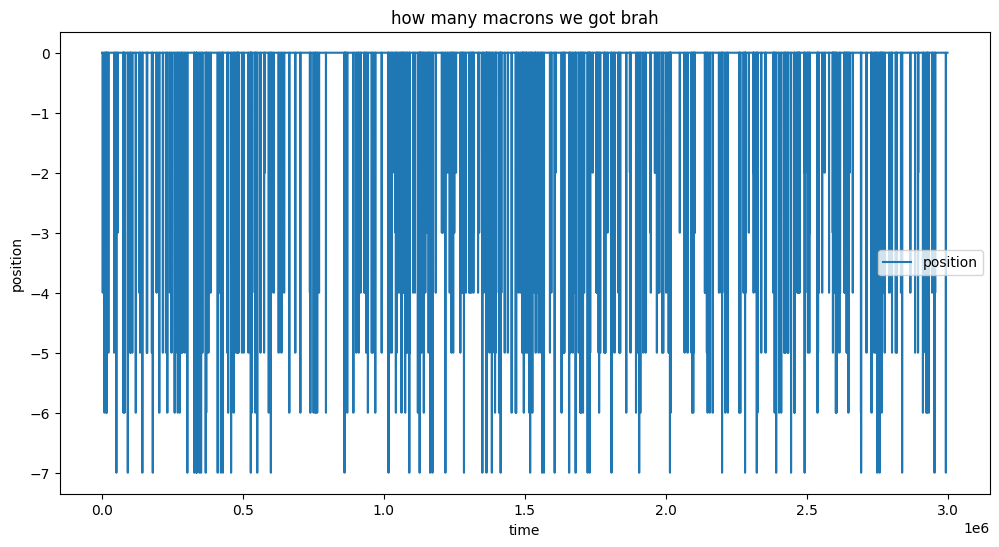

In [5]:
metrics = bt.calculate_metrics("MAGNIFICENT_MACARONS")

print(f"Available metrics:")
for idx, key in enumerate(metrics.keys()):
    print(f"{idx}: {key}")

# metrics['timestamp'] is provided for convenience.
# this should line up with metrics['midpoint_pnl'] and metrics['spreadcrossing_pnl'] (i.e. same shape)

plt.figure(figsize=(12, 6))
plt.plot(metrics["timestamp"], metrics["midpoint_pnl"], label="midpoint_pnl")
plt.plot(metrics["timestamp"], metrics["spreadcrossing_pnl"], label="spreadcrossing_pnl")
plt.title("yummy macrons")
plt.xlabel("time")
plt.ylabel("profit")
plt.legend()


plt.figure(figsize=(12, 6))
plt.plot(metrics["timestamp"], metrics["position"], label="position")
plt.title("how many macrons we got brah")
plt.xlabel("time")
plt.ylabel("position")
plt.legend()



In [12]:
import plotly.graph_objects as go

# Filter for the product
md = market_data_round_5_all3days.copy()
md = md[md['product'] == MAGNIFICENT_MACARONS].reset_index(drop=True)

obs = observations_round_5_all3days.copy().reset_index(drop=True)

# Compute chef_ask
md['chef_ask'] = obs['askPrice'] + obs['importTariff'] + obs['transportFees']

# Create figure
fig = go.Figure()

# Add chef_ask trace
fig.add_trace(go.Scatter(
    x=md['timestamp'],
    y=md['chef_ask'],
    mode='lines',
    name='Chef Ask'
))

# Add bid_price_1 trace
fig.add_trace(go.Scatter(
    x=md['timestamp'],
    y=md['bid_price_1'],
    mode='lines',
    name='Bid Price 1'
))

# Add bid_price_1 + 3 trace
fig.add_trace(go.Scatter(
    x=md['timestamp'],
    y=md['bid_price_1'] + 3,
    mode='lines',
    name='Bid Price 1 + 3'
))

# Update layout
fig.update_layout(
    title='Chef Ask vs Bid Price 1 (+3) for MAGNIFICENT_MACARONS',
    xaxis_title='Timestamp',
    yaxis_title='Price',
    height=600,
    width=1000
)

# Show plot
fig.show()
